### SOLUTION :


In [1]:
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df = df.sample(frac=1, random_state=42)
train_size = round(df.shape[0]*0.8)
test_size = df.shape[0] - train_size

train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 256 to 1126
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  1897 non-null   float64
 1   feature_2  1899 non-null   float64
 2   feature_3  1893 non-null   float64
 3   feature_4  1897 non-null   float64
 4   isVirus    1999 non-null   bool   
dtypes: bool(1), float64(4)
memory usage: 80.0 KB


<AxesSubplot: ylabel='isVirus'>

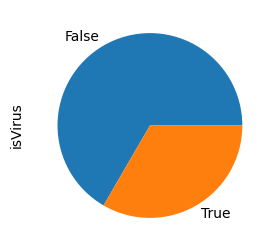

In [5]:
plt.figure(figsize=(3,3))
df['isVirus'].value_counts().plot.pie()

**There is no need for balancing data**

Text(20.72222222222222, 0.5, 'Missing Values')

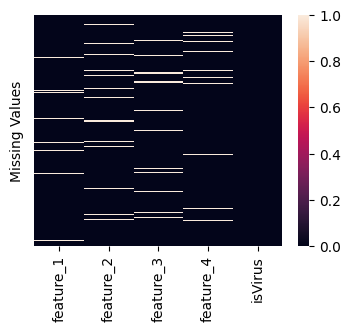

In [6]:
# Look for Missing Values
plt.figure(figsize=(4,3))
sns.heatmap(df.isna())
plt.yticks([])
plt.ylabel('Missing Values')

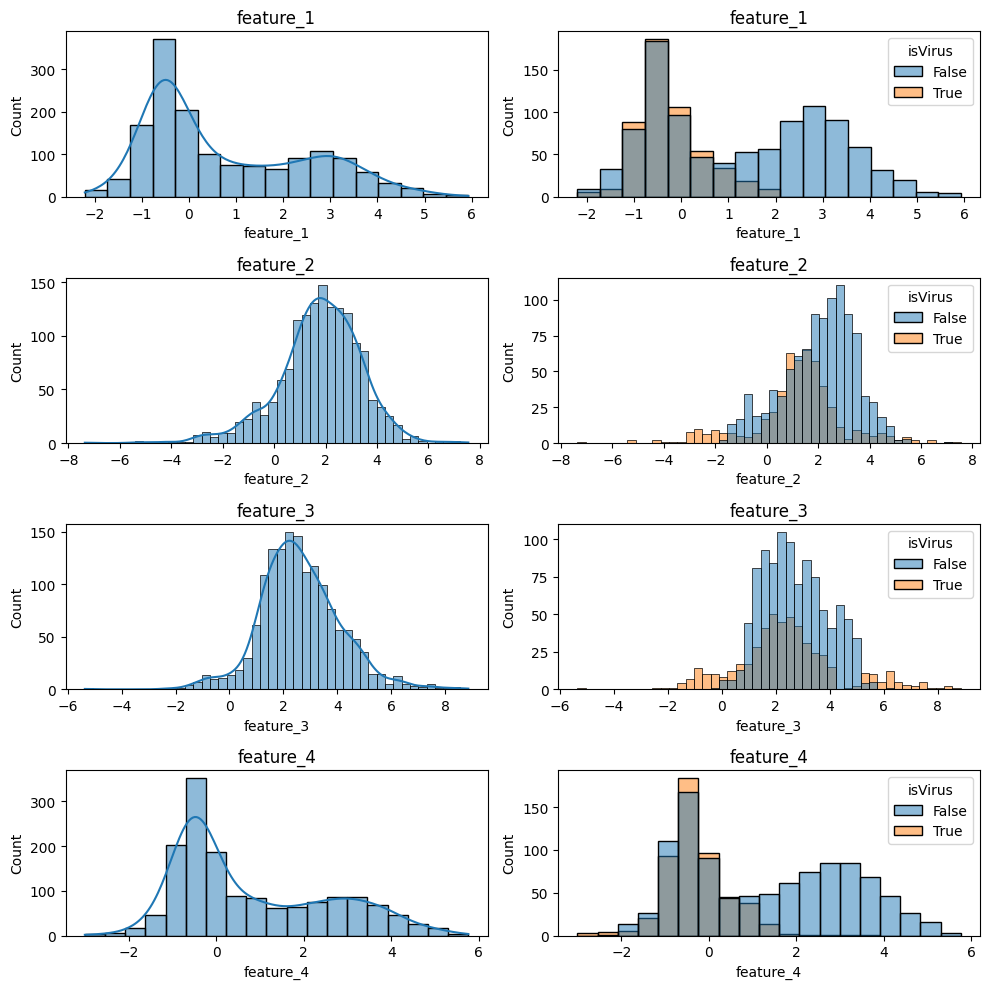

In [7]:
# Visualizing Data

fig=plt.figure(figsize=(10,10))
for i, var_name in enumerate(train.columns[:-1]):
    # Left plot
    ax=fig.add_subplot(4,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, kde=True)
    ax.set_title(var_name)

    # Mid plot
    ax=fig.add_subplot(4,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, kde=False, hue='isVirus')
    ax.set_title(var_name)

fig.tight_layout()
plt.show()


In [8]:
# Acceptable skewness value is between -3 and 3
train.skew()

feature_1    0.70
feature_2   -0.64
feature_3    0.25
feature_4    0.72
isVirus      0.69
dtype: float64

**No need for log transformation**

<AxesSubplot: >

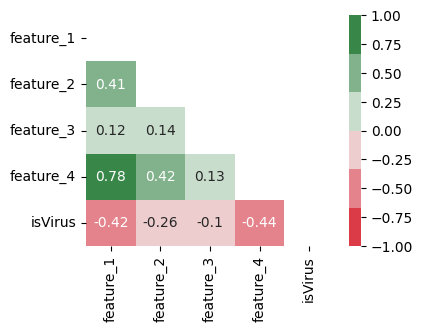

In [9]:
cmap = sns.diverging_palette(10,133)

plt.figure(figsize=(4,3))
sns.heatmap(data=train.corr(),
            annot=True,
            cmap=cmap,
            vmin=-1,
            vmax=1,
            mask=np.triu(train.corr()))

**Feature_1 and Feature_4 has effect on Virus label at first look, but also they are correlated with each other, I may use dimension reduction to prevent overfitting**

In [10]:
# Filling missing values with nearest neighborhood method
knnimputer = KNNImputer(n_neighbors=5)

train = pd.DataFrame(knnimputer.fit_transform(train), columns=df.columns)
test = pd.DataFrame(knnimputer.transform(test), columns=df.columns)

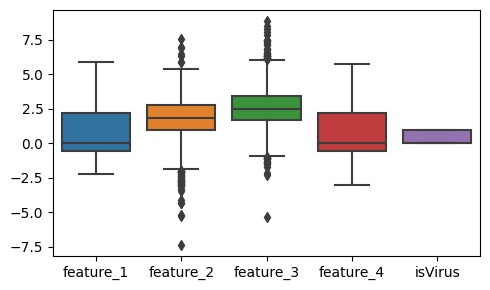

In [11]:
# Look for outliers
plt.figure(figsize=(5,3))
sns.boxplot(train)
plt.tight_layout()

In [12]:
def find_outliers(df, ft):
    Q1 = train[ft].quantile(0.25)
    Q3 = train[ft].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    ls = df.index[ (df[ft] < lower_bound) | (df[ft] > upper_bound) ]

    return ls



def remove_outliers(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls, axis=0)
    return df

In [13]:
outlier_index_list_train = []
for feature in train.columns[:-1]:
    outlier_index_list_train.extend(find_outliers(train, feature))

outlier_index_list_test = []
for feature in test.columns[:-1]:
    outlier_index_list_test.extend(find_outliers(test, feature))

train = remove_outliers(train, outlier_index_list_train)
test = remove_outliers(test, outlier_index_list_test)

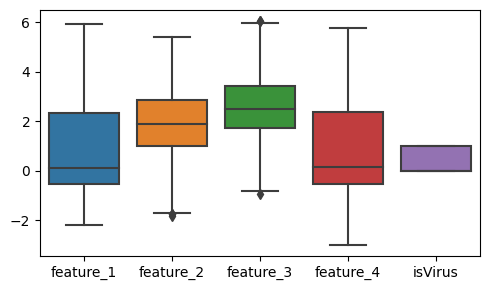

In [14]:
# Look for outliers after outlier removing
plt.figure(figsize=(5,3))
sns.boxplot(train)
plt.tight_layout()

In [15]:
X_train = train.drop('isVirus', axis=1)
y_train = train['isVirus']

X_test = test.drop('isVirus', axis=1)
y_test = test['isVirus']

In [16]:
# Before PCA
lazy = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     classifiers='all')

models, predictions = lazy.fit(X_train , X_test , y_train , y_test)
models

100%|██████████| 29/29 [00:03<00:00,  8.89it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelSpreading,0.90,0.85,0.85,0.90,0.16
LabelPropagation,0.90,0.85,0.85,0.89,0.10
KNeighborsClassifier,0.89,0.83,0.83,0.88,0.03
ExtraTreesClassifier,0.88,0.82,0.82,0.87,0.23
RandomForestClassifier,0.88,0.82,0.82,0.87,0.40
BaggingClassifier,0.86,0.79,0.79,0.85,0.09
LGBMClassifier,0.85,0.79,0.79,0.84,0.12
XGBClassifier,0.84,0.79,0.79,0.84,1.21
AdaBoostClassifier,0.83,0.77,0.77,0.82,0.32


In [17]:
# KNN model and PCA requires scaling process, Bagging methods does not require scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Reducing overfitting that might be caused of correlation
pca = PCA(n_components=3)
pca.fit(X_train)
pca.explained_variance_ratio_.sum()

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [19]:
# After PCA
lazy = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     classifiers='all')

models, predictions = lazy.fit(X_train , X_test , y_train , y_test)
models

100%|██████████| 29/29 [00:01<00:00, 16.72it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.86,0.82,0.82,0.86,0.02
LabelPropagation,0.86,0.80,0.80,0.85,0.07
LabelSpreading,0.85,0.80,0.80,0.85,0.11
LGBMClassifier,0.85,0.80,0.80,0.85,0.11
XGBClassifier,0.84,0.79,0.79,0.84,0.14
BaggingClassifier,0.85,0.79,0.79,0.85,0.06
RandomForestClassifier,0.84,0.78,0.78,0.84,0.28
DecisionTreeClassifier,0.82,0.77,0.77,0.82,0.01
NearestCentroid,0.70,0.77,0.77,0.71,0.17


In [20]:
# Visualizing Results 
# Accuracy
line = px.line(data_frame= models ,y =["Accuracy"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Model Accuracy',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [21]:
# roc auc, f1
line = px.line(data_frame= models ,y =["ROC AUC" , "F1 Score"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "ROC AUC SCORE")
line.update_layout(showlegend = True,
    title = {
        'text': 'ROC AUC and F1 Score of Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [22]:

classifiers = {
    "LGBM" : LGBMClassifier(random_state=42),
    "RandomForest" : RandomForestClassifier(random_state=42),
    "XGB" : XGBClassifier(random_state=42),
    "KNN" : KNeighborsClassifier()
}


KNN_grid = {
    "leaf_size":[1,10,20,30],
    "n_neighbors":[1,10,20,30],
    "p":[1,2]
}

boosted_grid = {'n_estimators': [50, 100, 150],
        'max_depth': [-1, 5, 10],
        'learning_rate': [0.05, 0.1, 0.15]}
RF_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 6, 8, 10, 12]}


grid = {
    "LGBM" : boosted_grid,
    "RandomForest" : RF_grid,
    "XGB": boosted_grid,
    "KNN": KNN_grid
}

In [23]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_test, y_test)

    # Save trained model
    clf_best_params[key]=clf.best_params_

    i+=1

In [24]:
clf_best_params

{'LGBM': {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 150},
 'RandomForest': {'max_depth': 12, 'n_estimators': 150},
 'XGB': {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50},
 'KNN': {'leaf_size': 1, 'n_neighbors': 10, 'p': 1}}

In [25]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LGBM,0.85,0.00
1,RandomForest,0.85,0.00
2,XGB,0.86,0.00
3,KNN,0.86,0.00


In [26]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

print(classification_report( y_test, knn.predict(X_test) ))

              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91       273
         1.0       0.84      0.64      0.73       112

    accuracy                           0.86       385
   macro avg       0.85      0.80      0.82       385
weighted avg       0.86      0.86      0.85       385



In [27]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=50)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

print(classification_report( y_test, xgb.predict(X_test) ))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90       273
         1.0       0.82      0.65      0.73       112

    accuracy                           0.86       385
   macro avg       0.84      0.80      0.81       385
weighted avg       0.85      0.86      0.85       385

